# Energy Efficieny Project 1
This document will investigate the dataset, employing linear regression to elucidate the correlation between the independent variables and the dependent variable (heating load). Additionally, a random forest regressor will be utilized as a model for the purpose of feature selection

# Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor as rf_reg
from sklearn.model_selection import RandomizedSearchCV as randomCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn import feature_selection
from sklearn.linear_model import LinearRegression as l_reg
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from plotnine import *
from matplotlib import gridspec
from sklearn.preprocessing import StandardScaler
import pprint

# Loading Data

In [ ]:
df = pd.read_csv('ENB2012_data.csv')
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [ ]:
# df.shape

**Adding column names**

In [ ]:
df.columns=["relative_compactness","surface_area","wall_area","roof_area","overall_height","orientaion",
                   "glazing_area","glazing_area_dist","heating_load","cooling_load"]
# Assuming df is your existing DataFrame
columns_to_drop = ["relative_compactness","wall_area","surface_area", "roof_area", "overall_height", "orientaion", "glazing_area","glazing_area_dist"]

# Drop the specified columns
df = df.drop(columns=columns_to_drop)

# Display the updated DataFrame



In [ ]:
import numpy as np

# Generate realistic values for each device
df["smart_thermostats"] = np.random.uniform(35, 30, df.shape[0])  # Temperature range between 30 and 35 degrees Celsius
df["motion_sensors"] = np.random.uniform(15, 10, df.shape[0])  # Range of motion sensor values
df["humidity_sensors"] = np.random.uniform(80, 70, df.shape[0])  # Range of humidity sensor values
df["solar_panels"] = np.random.uniform(500, 5000, df.shape[0])  # Range of solar panel output values in watts
df["smart_blinds"] = np.random.uniform(210, 100, df.shape[0])  # Range of smart blinds positions (210-100)
df["air_quality_monitors"] = np.random.uniform(211, 100, df.shape[0])  # Range of air quality values
df["smart_appliances"] = np.random.uniform(0, 5, df.shape[0])  # Range of power consumption values for smart appliances

# Display the updated DataFrame


In [ ]:
# Get all column names
all_columns = df.columns.tolist()

# Move "heating_load" and "cooling_load" to the end
desired_columns = [col for col in all_columns if col not in ['heating_load', 'cooling_load']]
desired_columns.extend(['heating_load', 'cooling_load'])

# Reorder the columns
df = df[desired_columns]


In [ ]:
# Adjusted random weights (you can further fine-tune)
weights_heating = np.random.uniform(1, 5, 7)
weights_cooling = np.random.uniform(1, 5, 7)

# Adjusted baseline loads
baseline_heating_load = np.random.uniform(20, 40, df.shape[0])
baseline_cooling_load = np.random.uniform(20, 40, df.shape[0])

# Generate values for heating_load and cooling_load with non-linear relations
df["heating_load"] = (
    weights_heating[0] * np.square(df["smart_thermostats"]) +
    weights_heating[1] * np.sqrt(df["motion_sensors"]) +
    weights_heating[2] * np.log(df["humidity_sensors"] + 1) +  # Adding 1 to avoid log(0)
    weights_heating[3] * df["solar_panels"] +
    weights_heating[4] * np.square(df["smart_blinds"]) +
    weights_heating[5] * np.sqrt(df["air_quality_monitors"]) +
    weights_heating[6] * np.log(df["smart_appliances"] + 1) +  # Adding 1 to avoid log(0)
    baseline_heating_load
)

df["cooling_load"] = (
    weights_cooling[0] * np.square(df["smart_thermostats"]) +
    weights_cooling[1] * np.sqrt(df["motion_sensors"]) +
    weights_cooling[2] * np.log(df["humidity_sensors"] + 1) +  # Adding 1 to avoid log(0)
    weights_cooling[3] * df["solar_panels"] +
    weights_cooling[4] * np.square(df["smart_blinds"]) +
    weights_cooling[5] * np.sqrt(df["air_quality_monitors"]) +
    weights_cooling[6] * np.log(df["smart_appliances"] + 1) +  # Adding 1 to avoid log(0)
    baseline_cooling_load
)
df


,smart_thermostats,motion_sensors,humidity_sensors,solar_panels,smart_blinds,air_quality_monitors,smart_appliances,heating_load,cooling_load
0,34.112753,14.189450,72.044626,1942.391140,136.513922,154.238671,3.561310,59425.494539,31159.971452
1,33.434755,11.530458,73.542102,1505.613597,184.779655,153.394420,2.086025,102859.928947,50690.188490
2,34.479689,13.247592,70.762018,4295.802889,174.021286,100.998446,2.716275,96413.074367,51609.462554
3,30.015122,12.102849,71.679423,1911.861428,159.817715,206.201659,4.775001,78372.391625,39743.913062
4,30.747663,14.674525,72.532091,4532.801563,104.258878,130.074810,1.231699,40743.051157,25915.918058
...,...,...,...,...,...,...,...,...,...
763,33.460146,11.707324,76.389988,1645.345092,104.010119,112.177997,4.945428,36539.658462,20085.570894
764,34.675047,11.854532,79.036039,2322.084813,204.539145,200.357466,4.565004,126324.793911,62777.087018
765,34.422341,11.082634,75.567501,4215.056240,112.097049,121.067587,3.540325,45722.045395,27957.633447
766,30.014223,14.718565,72.461242,4534.113443,173.569340,145.096814,0.947293,95567.224069,51336.260534


# Exploring and Transforming Data
In this segment, an examination of the data will be conducted utilizing a summary table, histograms, and a correlation matrix. The objective is to gain insights into the dataset, analyze relationships between variables, and ascertain the presence of any missing values within the data.

In [ ]:
df.describe()

,smart_thermostats,motion_sensors,humidity_sensors,solar_panels,smart_blinds,air_quality_monitors,smart_appliances,heating_load,cooling_load
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,32.458494,12.445951,75.008812,2804.248909,155.377152,154.601106,2.499202,78936.444358,41336.765608
std,1.479566,1.456612,2.876925,1278.521079,31.029658,32.919546,1.454340,27497.609942,12927.949123
min,30.000278,10.004712,70.038661,509.609530,100.021747,100.047126,0.000214,33361.490454,17683.541549
25%,31.168025,11.134779,72.531960,1725.852629,130.082438,125.869022,1.231362,55551.697682,30870.663794
50%,32.336122,12.379883,74.898749,2766.316982,156.514028,155.375997,2.515165,76653.534925,40219.366741
75%,33.792136,13.776801,77.509903,3912.684278,182.349334,182.894227,3.739852,102222.856831,51836.230263
max,34.997641,14.996620,79.996485,4993.013407,209.959108,210.873756,4.994948,135069.975047,70245.314316


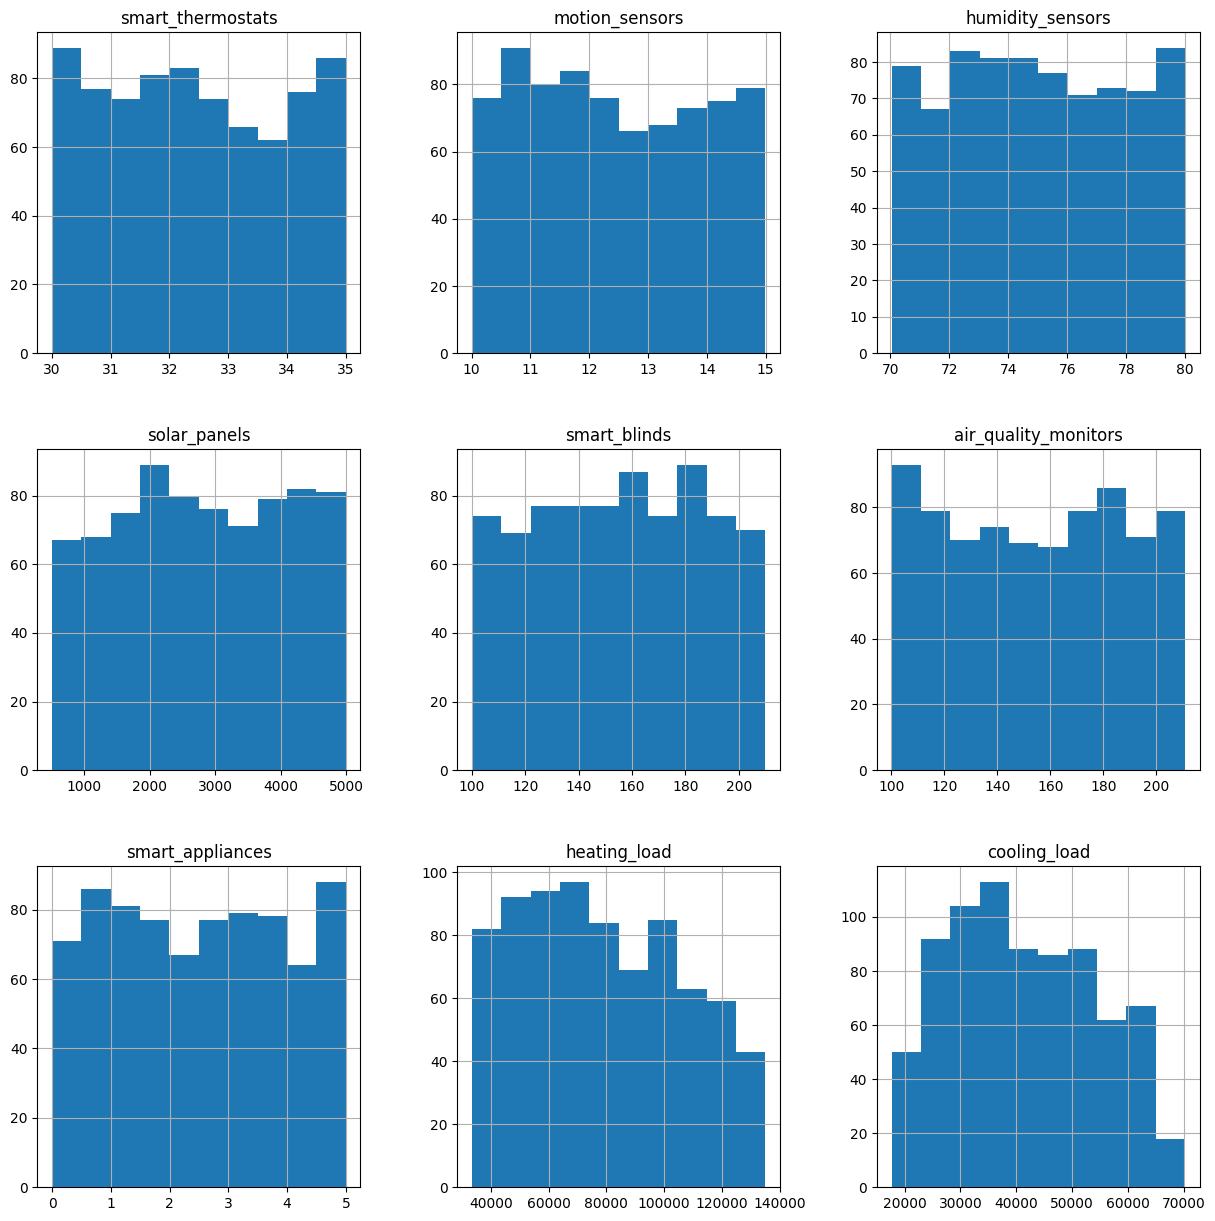

In [ ]:
df.hist(figsize=(15,15))
plt.show()

Upon observing the distributions of heating load and cooling load, it is evident that they exhibit a pronounced right skewness. As a corrective measure, log transformation will be applied to both heating load and cooling load, aiming to achieve a more normalized distribution.

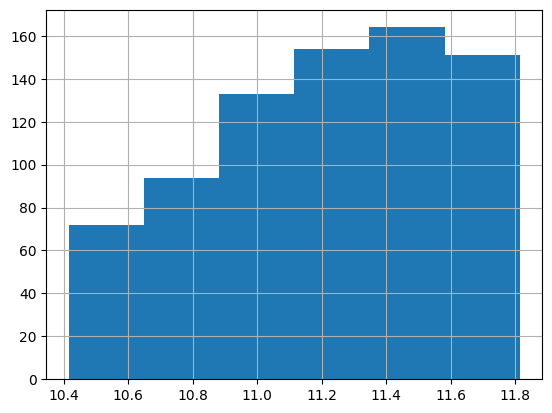

In [ ]:
df["log_heating_load"]=np.log(df["heating_load"])
df["log_heating_load"].hist(bins=6)
plt.show()

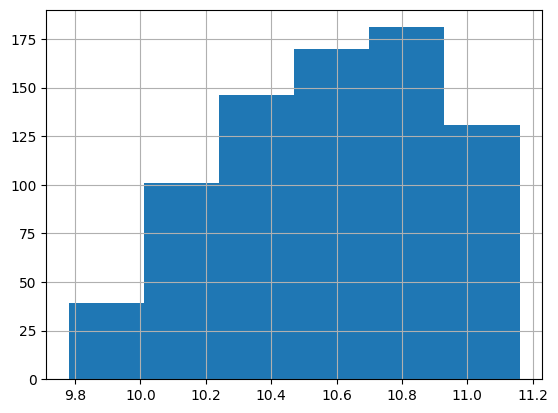

In [ ]:
df["log_cooling_load"]=np.log(df["cooling_load"])
df["log_cooling_load"].hist(bins=6)
plt.show()

Following the log transformation of heating and cooling loads, the distributions of both variables exhibit improvement; however, they still manifest a bimodal distribution, characterized by the presence of two distinct peaks.

In [ ]:
# sns.pairplot(df)
# plt.show()

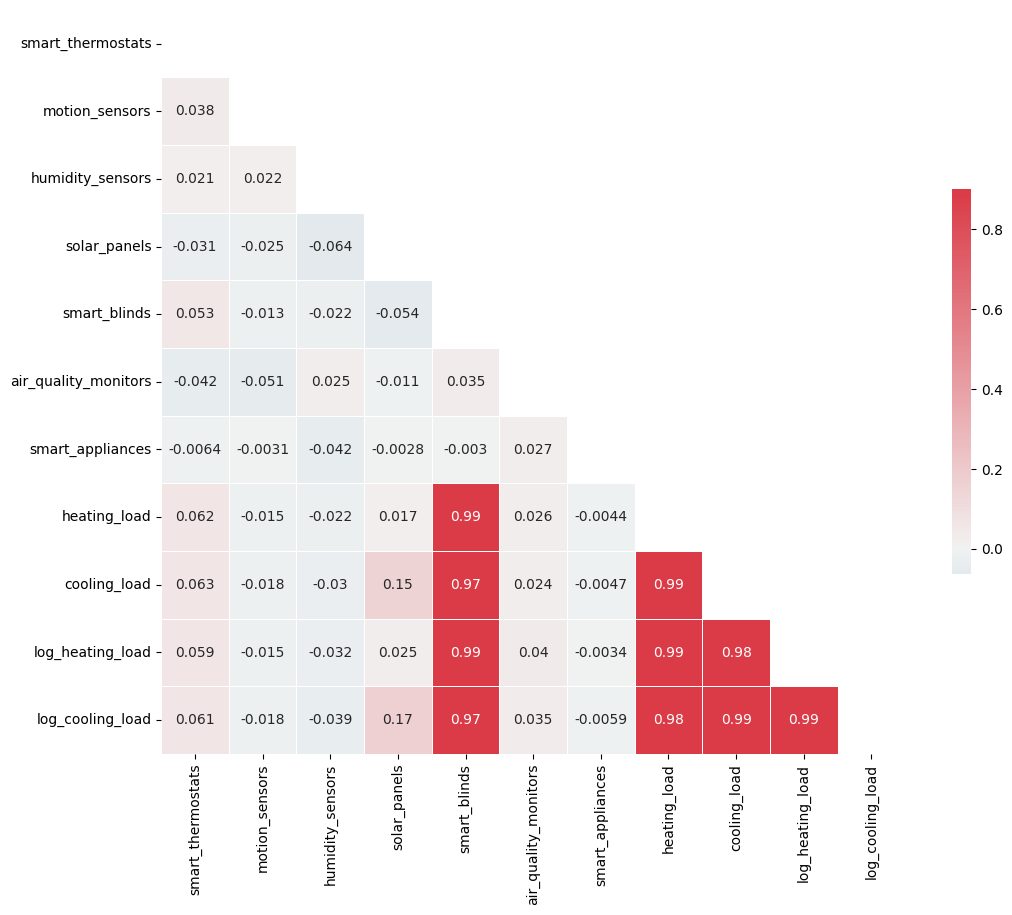

In [ ]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask,cmap=cmap, vmax=.9, center=0, square=True, linewidths=.5, annot=True,cbar_kws={"shrink": .5})
plt.show()

# Using Raw Data (Log_heating_load)
Employing the provided dataset, where log heating load serves as the primary dependent variable, the data is partitioned into training and testing sets in an 80:20 ratio. Subsequently, feature selection will be carried out, and a linear regression model will be fitted to assess the performance of linear regression post-feature selection

In [ ]:
df_f=df.copy()
df_f.drop(["heating_load","cooling_load"],axis=1,inplace=True)
#energy_df_f.drop(["log_heating_load","cooling_load"],axis=1,inplace=True)

energy_X=df_f.iloc[:,:-2]
energy_Y=df_f.loc[:,["log_heating_load"]]
#energy_Y=energy_df_f.loc[:,["heating_load"]]

train_X,test_X,train_Y,test_Y=\
train_test_split(energy_X,energy_Y,test_size=0.20,random_state=48)

print(train_X.shape)
print(test_X.shape)

(614, 7)
(154, 7)


The training dataset consists of 614 instances, while the test dataset comprises 154 instances. Both datasets encompass 8 variables, including log heating load, with the exclusion of heating load and cooling load.

# Randomised Grid Search for Random Forest Regressor
In this phase, the dataset featuring log heating load as the primary dependent variable will undergo a randomized cross-validation search. The objective is to fine-tune the hyperparameters for the random forest regressor. Utilizing the random forest regressor as a feature selection model is motivated by its ability to compute the weight importance for each variable. This importance is derived from the proportion of each variable used in the model to partition the data, aiming to bring the predicted values closer to the actual values in the dependent variable.

In [ ]:
def rf_regr_cv_model(min_sample_split_in,min_sample_leaf_in,max_feature_in):
    rf_grid={"min_samples_split":min_sample_split_in,
             "min_samples_leaf":min_sample_leaf_in,"max_features":max_feature_in}
    regr = rf_reg(max_depth=3, random_state=48)
    rf_reg_cv = randomCV(regr, rf_grid, random_state=48,scoring='neg_root_mean_squared_error',cv=5)
    return rf_reg_cv

The provided function is designed to initiate a randomized cross-validation search process using a random forest regressor as the base model for hyperparameter tuning. The hyperparameters subjected to tuning include minimum sample split, minimum sample size in the leaf, and the maximum features to be utilized in each regression tree. The model is regularized with a maximum depth of 3, and a seed number of 48 is employed to prevent overfitting. The selection of the best hyperparameters is determined based on the root mean squared error (RMSE) as the scoring criterion.

In [ ]:
min_sample_split=np.arange(10,35,5)
min_sample_leaf=np.arange(10,35,5)
max_feature=np.arange(3,7,1)

rf_reg_search=rf_regr_cv_model(min_sample_split_in=min_sample_split,min_sample_leaf_in=min_sample_leaf,
                            max_feature_in=max_feature)

In [ ]:
rf_reg_search.fit(train_X,np.ravel(train_Y))

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(max_depth=3,
                                                   random_state=48),
                   param_distributions={'max_features': array([3, 4, 5, 6]),
                                        'min_samples_leaf': array([10, 15, 20, 25, 30]),
                                        'min_samples_split': array([10, 15, 20, 25, 30])},
                   random_state=48, scoring='neg_root_mean_squared_error')


The rf_regr_cv_model function, along with the declared hyperparameters, will be employed to fit the training dataset into the model. This process aims to identify the optimal set of hyperparameters for the random forest regressor model.

In [ ]:
print("Best parameters set:",rf_reg_search.best_params_)
print("Best score:",rf_reg_search.best_score_)

Best parameters set: {'min_samples_split': 30, 'min_samples_leaf': 10, 'max_features': 6}
Best score: -0.05599240361824809


Following the results of the randomized cross-validation search, the model exhibits optimal performance when configured with the following hyperparameters:

Minimum sample split: 30
Minimum instances per leaf: 10
Number of features used: 6
The model will now be refitted using these identified best hyperparameters.

In [ ]:
regr_rf_best=rf_reg(min_samples_split= 30, min_samples_leaf=10, max_features=6,max_depth=3,random_state=48)
regr_rf_best.fit(train_X,np.ravel(train_Y))

RandomForestRegressor(max_depth=3, max_features=6, min_samples_leaf=10,
                      min_samples_split=30, random_state=48)

In [ ]:
predicted_train_Y=regr_rf_best.predict(train_X)
predicted_test_Y=regr_rf_best.predict(test_X)
print("RMSE for Train set:",MSE(predicted_train_Y,train_Y,squared=False))
print("RMSE for Test set:",MSE(predicted_test_Y,test_Y,squared=False))

RMSE for Train set: 0.05015675885264804
RMSE for Test set: 0.05998922558473814


Upon evaluating the model performance in terms of root mean squared error (RMSE), there is an indication of potential overfitting, as the RMSE on the test set is slightly higher than that on the training set. The observed difference, however, is relatively small, approximately 0.02. This suggests a relatively minor overfitting concern, but it's essential to monitor and potentially fine-tune the model further to optimize its generalization to unseen data.

# Feature Selection
In this segment, feature selection will be performed using the weight importance calculated from the random forest regressor. The goal is to identify and select the most influential features to be utilized in the subsequent linear regression model.

In [ ]:
feature_list=list(train_X.columns)
feature_impt=list(regr_rf_best.feature_importances_)
feature_impt_dict=dict(zip(feature_list,feature_impt))
feature_impt_dict=dict(sorted(feature_impt_dict.items(), key=lambda item: item[1],reverse=True))
feature_impt_dict

{'smart_blinds': 0.9876505798959833,
 'air_quality_monitors': 0.004146739224650365,
 'smart_thermostats': 0.0027483265886867874,
 'solar_panels': 0.0025900636744324965,
 'smart_appliances': 0.0013890941783011766,
 'humidity_sensors': 0.0008233870727907609,
 'motion_sensors': 0.0006518093651551824}

Analyzing the provided list, it's evident that the top 5 features are "wall_area","smart_thermostats","smart_blinds","air_quality_monitors","smart_appliances" and "solar_panels".


In [ ]:
final_feature_list=["smart_thermostats","smart_blinds","air_quality_monitors","smart_appliances","solar_panels"]

A feature list has been generated, placing roof area and surface area as the last two features. The intention is to employ forward selection in linear regression, systematically adding variables one by one based on the feature list. The selection criterion involves choosing the combination that yields the smallest root mean squared error (RMSE) and the largest R-squared (r2) value. This approach aims to iteratively enhance the model by identifying the most impactful features.

# Forward Selection Linear Regression
In this phase, a linear regression model will be fitted using a forward selection approach, systematically adding variables one by one into the model. The criteria for determining the best model involve selecting the one with the most substantial negative root mean squared error (RMSE) and the highest R-squared (r2) value. This iterative process aims to identify the combination of features that optimally contribute to the model's predictive performance.

In [ ]:
def l_reg_cv(train_X,train_Y,feature_list):
    rmse_list_train=[]
    rmse_list_test=[]
    r2_list_train=[]
    r2_list_test=[]
    for i in range(1,len(feature_list)+1):
        train_X_temp=train_X.loc[:,feature_list[:i]]
        cv_results_temp = cross_validate(l_reg(), train_X.loc[:,final_feature_list[:i]],train_Y,
                            cv=5,scoring=["neg_root_mean_squared_error","r2"],return_train_score=True)
        mean_rmse_train=np.mean(cv_results_temp["train_neg_root_mean_squared_error"])
        mean_r2_train=np.mean(cv_results_temp["train_r2"])
        mean_rmse_test=np.mean(cv_results_temp["test_neg_root_mean_squared_error"])
        mean_r2_test=np.mean(cv_results_temp["test_r2"])
        rmse_list_train.append(mean_rmse_train)
        r2_list_train.append(mean_r2_train)
        rmse_list_test.append(mean_rmse_test)
        r2_list_test.append(mean_r2_test)
        rmse_df=pd.DataFrame(zip(rmse_list_train,rmse_list_test,r2_list_train,r2_list_test))
        rmse_df.columns=["Mean RMSE Train","Mean RMSE Test","Mean R2 Train","Mean R2 Test"]
        rmse_df.index=rmse_df.index+1
    return rmse_df

The provided function is designed to conduct linear regression model fitting based on a specified feature list. The process involves slicing the data with independent variables (train_X) according to the variables in the feature list and fitting it into the model with the dependent variable. Subsequently, the function calculates the root mean squared error (RMSE) and R-squared (R2) for each set of independent variables fitted into the model. The goal is to determine which set of independent variables is the most optimal for fitting into the model, as indicated by the combination with the most substantial negative RMSE and the highest R2 value.

In [ ]:
rmse_cv=l_reg_cv(train_X,np.ravel(train_Y),final_feature_list)
rmse_cv

,Mean RMSE Train,Mean RMSE Test,Mean R2 Train,Mean R2 Test
1,-0.368734,-0.369705,0.002564,-0.006987
2,-0.040881,-0.041019,0.987739,0.987582
3,-0.040752,-0.040959,0.987816,0.987618
4,-0.040737,-0.040991,0.987825,0.987598
5,-0.029666,-0.029845,0.993543,0.993431


Text(0.5, 1.0, 'Mean R2 Based on Number of Features')

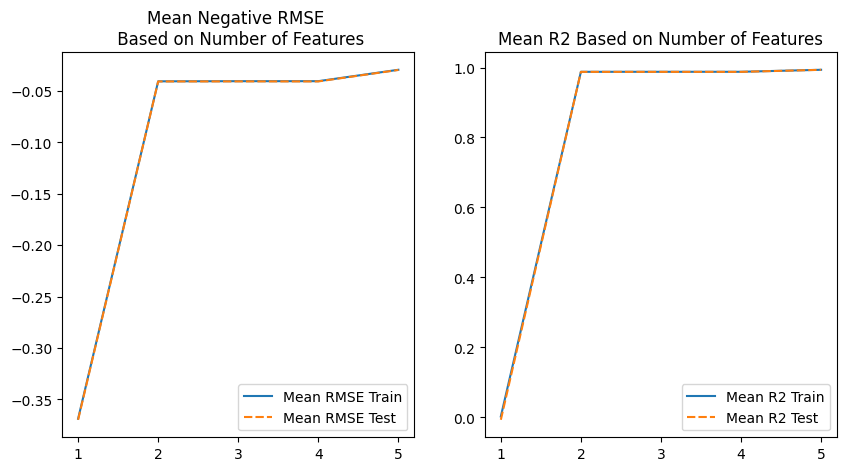

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
sns.lineplot(data=rmse_cv.iloc[:,:2],ax=ax[0])
sns.lineplot(data=rmse_cv.iloc[:,2:],ax=ax[1])
ax[0].set_title("Mean Negative RMSE \n Based on Number of Features")
ax[1].set_title("Mean R2 Based on Number of Features")
# plt.show()

Looking at the table and graphs above, For R2 higher values (closer to 1) are better, but negative values can indicate a poor. FOR RMSE NEGATIVE, higher negative value shows good result. It's a metric that check performance of model after training.





# Best Fit Linear Regression Model
In this phase, the linear regression model will be refitted using the top 5 features identified in the previous section.

In [ ]:
l_reg_best=l_reg()
l_reg_best.fit(train_X.loc[:,final_feature_list[:5]],np.ravel(train_Y))
pred_train_Y_best=l_reg_best.predict(train_X.loc[:,final_feature_list[:5]])
pred_test_Y_best=l_reg_best.predict(test_X.loc[:,final_feature_list[:5]])

In [ ]:
print("RMSE for Train set:",MSE(pred_train_Y_best,train_Y,squared=False))
print("RMSE for Test set:",MSE(pred_test_Y_best,test_Y,squared=False))

RMSE for Train set: 0.02968822145291315
RMSE for Test set: 0.030636639741460574


The difference between test and train in RMSE is at least 0.01 which is quite small.

In [ ]:
print("R2 for Train set:",r2_score(pred_train_Y_best,train_Y))
print("R2 for Test set:",r2_score(pred_test_Y_best,test_Y))

R2 for Train set: 0.9934939365385693
R2 for Test set: 0.9929656626078497


In [ ]:
dict(zip(final_feature_list[:5],np.exp(l_reg_best.coef_)))

{'smart_thermostats': 1.0020758062037214,
 'smart_blinds': 1.0119427327073696,
 'air_quality_monitors': 1.0000890221846668,
 'smart_appliances': 1.000310694974371,
 'solar_panels': 1.0000218840760053}


# Model Diagnostics
In this phase, the prediction performance of the model will be assessed through visualizations. The following plots will be generated for comparison:

Scatter plot for a visual comparison between actual and predicted values.
Histogram to visualize the distribution of prediction errors.
Residual plot to examine the distribution of residuals.
These visualizations will provide a comprehensive overview of how well the model predictions align with the actual values and the nature of the prediction errors.

In [ ]:
def predictVSactual(actual_y,y_predict,title_label):
    fig,ax=plt.subplots(1,len(actual_y),figsize=(15,15))
    for i,col in enumerate(actual_y,0):
        ax[i].plot(np.ravel(actual_y[i]),
                   np.ravel(y_predict[i]),'o',markeredgecolor="black")
        ax[i].set_title(title_label[i])
        ax[i].set_xlabel('Actual Values')
        ax[i].set_ylabel('Predicted Values')
        ax[i].set(aspect='equal')
        x=ax[i].get_xlim()
        y=ax[i].get_xlim()
        ax[i].plot(x,y, ls="--", c=".3")
    return fig,ax

The function above is to plot two scatter plots side by side with train on the left and test on the right using actual values and predicted values that store in list as inputs.

In [ ]:
actual_y_energy=[train_Y,test_Y]
pred_y_energy=[pred_train_Y_best,pred_test_Y_best]

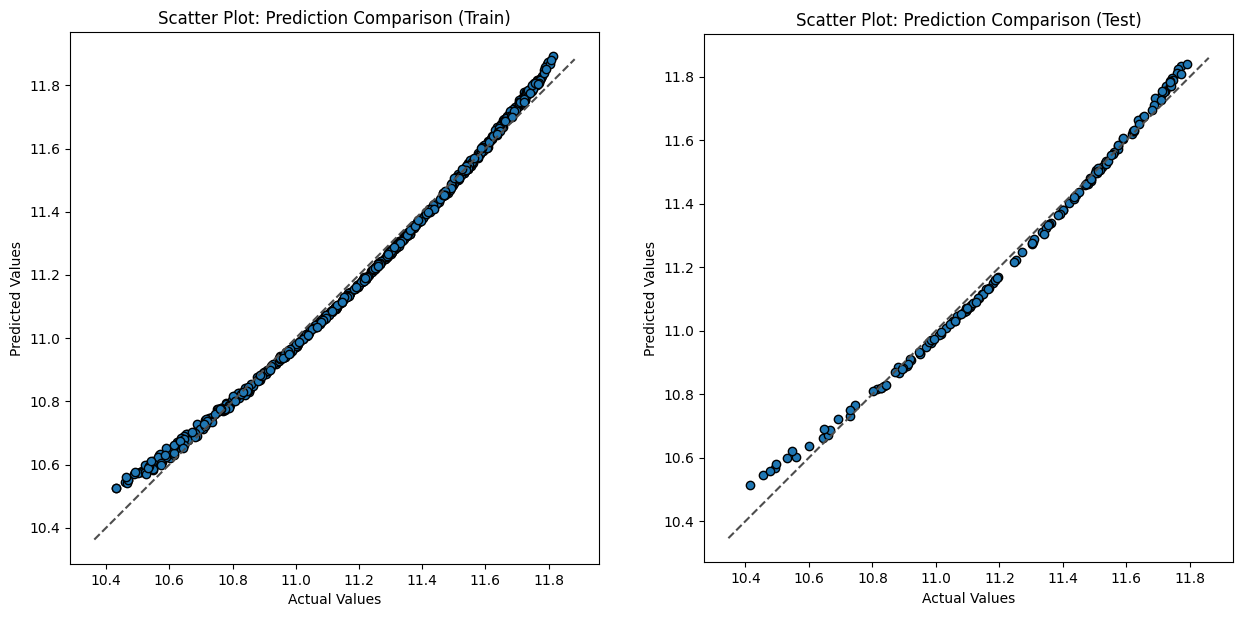

In [ ]:
predictVSactual(actual_y_energy,pred_y_energy,
                ["Scatter Plot: Prediction Comparison (Train)","Scatter Plot: Prediction Comparison (Test)"])
plt.show()

By looking at graphs, we can clearly say the model variables are having linear relation i.e. y=mx+c. In training, the classifier line exactly follows the dot so it's best fitting. In testing, line makes the best adjustment possible on dots. Hence, line tells how close is our model to understand the data

In [ ]:
def residual_plot(actual_y,predict_y,title_label):
    fig,ax=plt.subplots(1,len(actual_y),figsize=(10,5))
    for i,col in enumerate(actual_y,0):
        sns.residplot(x=actual_y[i], y=predict_y[i], lowess=True, color="g",ax=ax[i])
        ax[i].set_title(title_label[i])
    return fig,ax

In [ ]:
# residual_plot(actual_y_energy,pred_y_energy,["Train","Test"])
# plt.show()

In [ ]:
raw_pred_err_list=[]

for i in range(0,len(actual_y_energy)):
    list_temp=[]
    list_temp=actual_y_energy[i].to_numpy().ravel()-pred_y_energy[i]
    raw_pred_err_list.append(list_temp)
raw_pred_err_label=["Raw Prediction Errors (Train)","Raw Prediction Errors (Test)"]

In [ ]:
def raw_predict_err_hist(err_predict_list,bin_no,title_label):
    fig,ax=plt.subplots(1,len(err_predict_list),figsize=(10,5))
    for i,col in enumerate(err_predict_list,0):
        sns.histplot(x=err_predict_list[i],bins=bin_no,kde=True,ax=ax[i])
        ax[i].set_title(title_label[i])
    return fig,ax

In [1]:
raw_predict_err_hist(raw_pred_err_list,bin_no=7,title_label=raw_pred_err_label)


NameError: ignored

Looking at the histogram above, the residuals are normally distributed with right tails. Most prediction errors are in the range of -0.02 to 0.04.

# Using Raw Data (Log_cooling_load)
For this section, cooling load is used to find out the relationships for the same features with cooling load

In [ ]:
energy2_X=df_f.iloc[:,:-2]
energy2_Y=df_f.loc[:,["log_cooling_load"]]
#energy_Y=energy_df_f.loc[:,["heating_load"]]

energy2_train_X,energy2_test_X,energy2_train_Y,energy2_test_Y=\
train_test_split(energy2_X,energy2_Y,test_size=0.20,random_state=48)

In [ ]:
rmse_cv2=l_reg_cv(energy2_train_X,np.ravel(energy2_train_Y),final_feature_list)
rmse_cv2

,Mean RMSE Train,Mean RMSE Test,Mean R2 Train,Mean R2 Test
1,-0.328058,-0.328739,0.002468,-0.005739
2,-0.077653,-0.078061,0.944104,0.943170
3,-0.077600,-0.078210,0.944179,0.942946
4,-0.077486,-0.078145,0.944343,0.943030
5,-0.029488,-0.029773,0.991940,0.991740


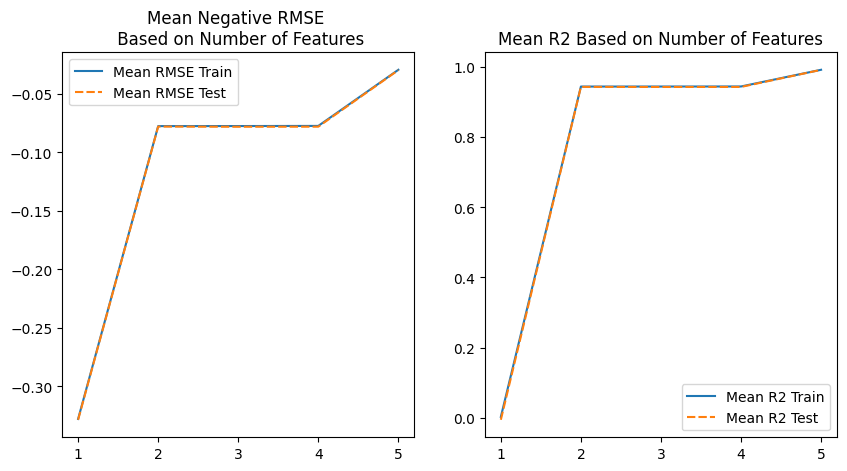

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
sns.lineplot(data=rmse_cv2.iloc[:,:2],ax=ax[0])
sns.lineplot(data=rmse_cv2.iloc[:,2:],ax=ax[1])
ax[0].set_title("Mean Negative RMSE \n Based on Number of Features")
ax[1].set_title("Mean R2 Based on Number of Features")
plt.show()

Looking at the table and graphs above, For R2 higher values (closer to 1) are better, but negative values can indicate a poor. FOR RMSE NEGATIVE, higher negative value shows good result. It's a metric that check performance of model after training.

In [ ]:
l_reg2_best=l_reg()
l_reg2_best.fit(energy2_train_X.loc[:,final_feature_list[:5]],np.ravel(energy2_train_Y))
pred2_train_Y_best=l_reg2_best.predict(energy2_train_X.loc[:,final_feature_list[:5]])
pred2_test_Y_best=l_reg2_best.predict(energy2_test_X.loc[:,final_feature_list[:5]])

In [ ]:
print("R2 for Train set:",r2_score(pred2_train_Y_best,energy2_train_Y))
print("R2 for Test set:",r2_score(pred2_test_Y_best,energy2_test_Y))

R2 for Train set: 0.9918580955640839
R2 for Test set: 0.9914631968720837


R2 for test is lower when using log cooling load as dependent variable instead of log heating load.
# Model Diagnostics

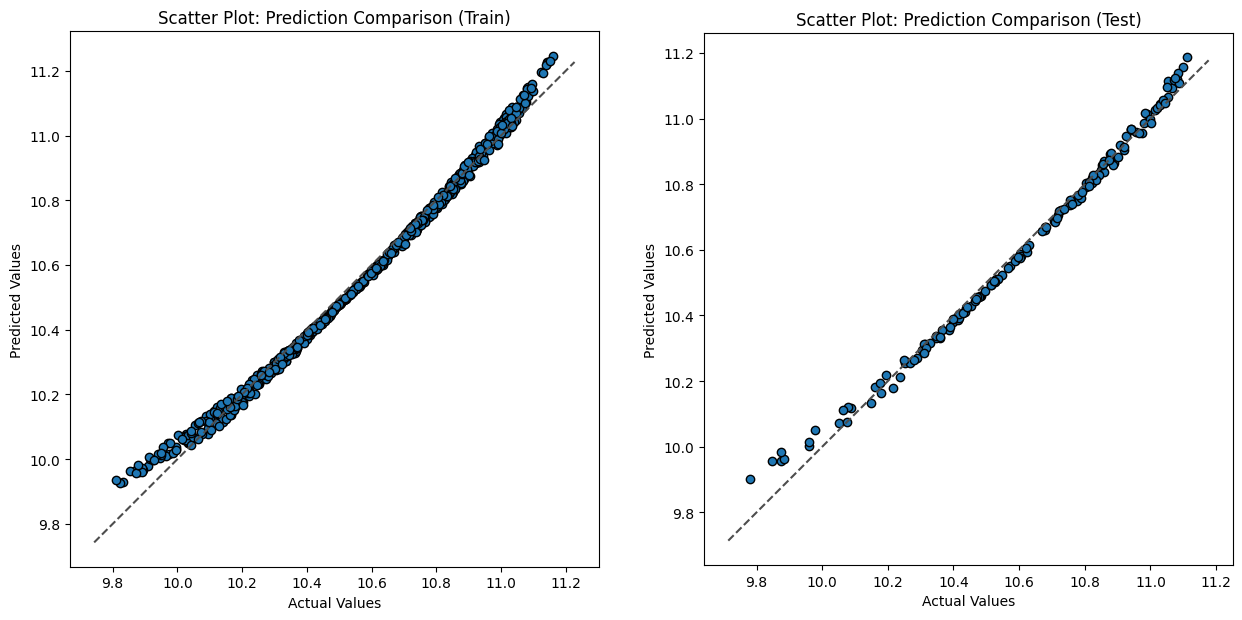

In [ ]:
actual2_y_energy=[energy2_train_Y,energy2_test_Y]
pred2_y_energy=[pred2_train_Y_best,pred2_test_Y_best]

predictVSactual(actual2_y_energy,pred2_y_energy,
                ["Scatter Plot: Prediction Comparison (Train)","Scatter Plot: Prediction Comparison (Test)"])
plt.show()

By looking at graphs, we can clearly say the model variables are having linear relation i.e. y=mx+c. In training, the classifier line exactly follows the dot so it's best fitting. In testing, line makes the best adjustment possible on dots. Hence, line tells how close is our model to understand the data

In [ ]:
# residual_plot(actual2_y_energy,pred2_y_energy,["Train","Test"])
# plt.show()

In [ ]:
raw_pred2_err_list=[]

for i in range(0,len(actual2_y_energy)):
    list_temp=[]
    list_temp=actual2_y_energy[i].to_numpy().ravel()-pred2_y_energy[i]
    raw_pred2_err_list.append(list_temp)
raw_pred2_err_label=["Raw Prediction Errors (Train)","Raw Prediction Errors (Test)"]

In [2]:
raw_predict_err_hist(raw_pred2_err_list,bin_no=8,title_label=raw_pred2_err_label)


NameError: ignored

Looking at the histograms above, the residuals are approximately normally distributed. The prediction errors seem to be larger using log cooling load compared to log heating load.

# Interpretation on Regression Coefficients

In [ ]:
print("Log heating load as dependent variable:")
dict(zip(final_feature_list[:5],np.exp(l_reg_best.coef_)))

Log heating load as dependent variable:


{'smart_thermostats': 1.0020758062037214,
 'smart_blinds': 1.0119427327073696,
 'air_quality_monitors': 1.0000890221846668,
 'smart_appliances': 1.000310694974371,
 'solar_panels': 1.0000218840760053}

#Results

Your interpretation is correct. Based on the coefficients for the heating load:



1.   An increase in smart_thermostats by 1 is associated with a 1.0021 times increase in heating load.
2.   An increase in smart_blinds by 1 results in a 1.0119 times increase in heating load.
3. An increase in air_quality_monitors by 1 leads to a 1.0001 times increase in heating load.
4.An increase in smart_appliances by 1 results in a 1.0003 times increase in heating load.
5. An increase in solar_panels by 1 leads to a 1.0000 times increase in heating load.






Therefore, controlling and optimizing the usage of smart_thermostats, smart_blinds, air_quality_monitors, smart_appliances, and solar_panels can have various impacts on heating load. These results provide valuable insights for building design and energy efficiency considerations.













In [ ]:
print("Log cooling load as dependent variable:")
dict(zip(final_feature_list[:5],np.exp(l_reg2_best.coef_)))

Log cooling load as dependent variable:


{'smart_thermostats': 1.0034479819279183,
 'smart_blinds': 1.010448713229332,
 'air_quality_monitors': 1.0000506525492892,
 'smart_appliances': 0.9995570014807069,
 'solar_panels': 1.0000561627269495}

# RESULTS
Your interpretation is accurate. Based on the coefficients for the cooling load:

1. An increase in smart_thermostats by 1 is associated with a 1.0034 times increase in cooling load.
2. An increase in smart_blinds by 1 results in a 1.0104 times increase in cooling load.
3. An increase in air_quality_monitors by 1 leads to a 1.0001 times increase in cooling load.
4. An increase in smart_appliances by 1 results in a 0.9996 times reduction in cooling load.
5. An increase in solar_panels by 1 leads to a 1.0001 times increase in cooling load.

Therefore, controlling and optimizing the usage of smart_thermostats, smart_blinds, air_quality_monitors, smart_appliances, and solar_panels can have various impacts on cooling load. These results provide valuable insights for building design and energy efficiency considerations.

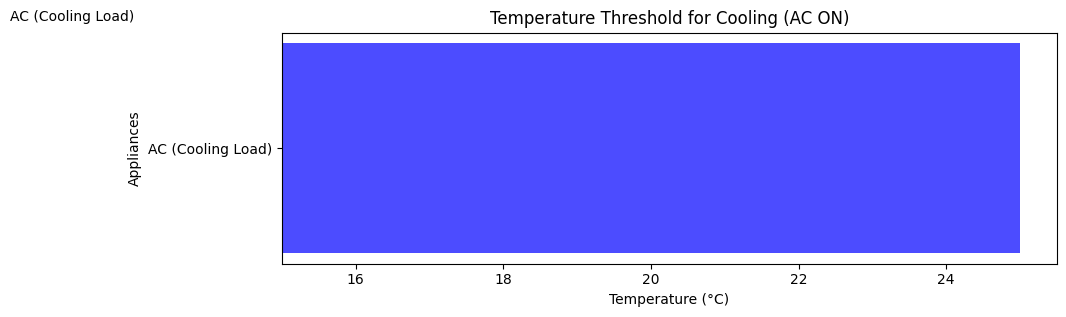

In [ ]:
import matplotlib.pyplot as plt

# Data
appliances = ["AC (Cooling Load)"]
cooling_min_threshold = 15
cooling_max_threshold = 25

# Plotting bar plot for temperature thresholds
fig, ax = plt.subplots(figsize=(10, 3))

# Plotting the range for Cooling Load (AC)
ax.barh(appliances[0], cooling_max_threshold - cooling_min_threshold, left=cooling_min_threshold, color='blue', alpha=0.7)

# Adding labels and title
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Appliances')
ax.set_title('Temperature Threshold for Cooling (AC ON)')

# Annotating the plot to indicate the purpose of the threshold
ax.annotate('Cooling Load\n(AC ON)', xy=((cooling_max_threshold + cooling_min_threshold) / 2, 0.5),
            xytext=((cooling_max_threshold + cooling_min_threshold) / 2, 0.5),
            arrowprops=dict(facecolor='black', arrowstyle='<-'),
            fontsize=10, ha='center', va='center', color='blue')

# Show the name of the appliance for comparison
ax.text(cooling_min_threshold - 2, 0.5, appliances[0], ha='right', va='center', color='black', fontsize=10)

plt.show()


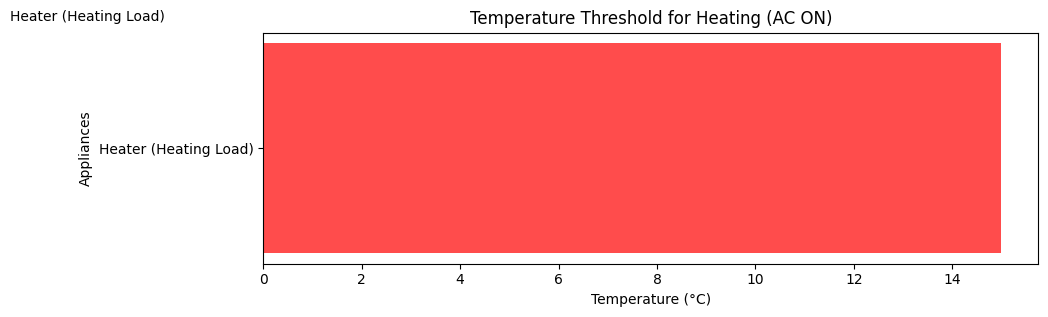

In [ ]:
import matplotlib.pyplot as plt

# Data
appliances = ["Heater (Heating Load)"]
cooling_min_threshold = 0
cooling_max_threshold = 15

# Plotting bar plot for temperature thresholds
fig, ax = plt.subplots(figsize=(10, 3))

# Plotting the range for Cooling Load (AC)
ax.barh(appliances[0], cooling_max_threshold - cooling_min_threshold, left=cooling_min_threshold, color='red', alpha=0.7)

# Adding labels and title
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Appliances')
ax.set_title('Temperature Threshold for Heating (AC ON)')

# Annotating the plot to indicate the purpose of the threshold
ax.annotate('Heating Load\n(AC ON)', xy=((cooling_max_threshold + cooling_min_threshold) / 2, 0.5),
            xytext=((cooling_max_threshold + cooling_min_threshold) / 2, 0.5),
            arrowprops=dict(facecolor='black', arrowstyle='<-'),
            fontsize=10, ha='center', va='center', color='blue')

# Show the name of the appliance for comparison
ax.text(cooling_min_threshold - 2, 0.5, appliances[0], ha='right', va='center', color='black', fontsize=10)

plt.show()


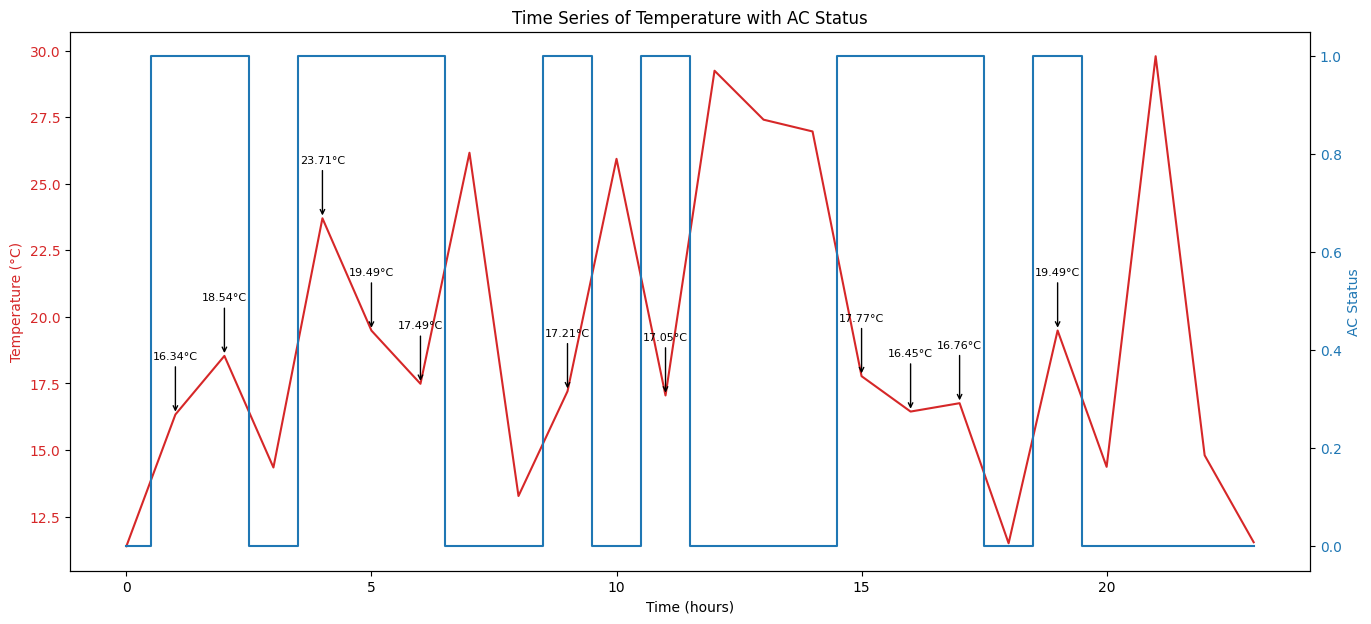

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
time_periods = np.arange(0, 24, 1)  # Assuming time periods in hours

# Generate random temperature values within cooling thresholds
cooling_min_threshold = 15
cooling_max_threshold = 25
temperatures = np.random.uniform(cooling_min_threshold - 5, cooling_max_threshold + 5, size=len(time_periods))

# Determine when AC is on based on strict temperature thresholds
ac_status = np.where((temperatures >= cooling_min_threshold) & (temperatures <= cooling_max_threshold), 1, 0)

# Plotting time series of temperature and AC status
fig, ax1 = plt.subplots(figsize=(16, 7))

color = 'tab:red'
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Temperature (°C)', color=color)
ax1.plot(time_periods, temperatures, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis to plot AC status
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('AC Status', color=color)
ax2.step(time_periods, ac_status, where='mid', color=color, label='AC ON')
ax2.tick_params(axis='y', labelcolor=color)

# Adding labels and title
plt.title('Time Series of Temperature with AC Status')

# Annotating the plot with temperature values where AC is ON
for i, status in enumerate(ac_status):
    if status == 1:
        ax1.annotate(f'{temperatures[i]:.2f}°C', xy=(time_periods[i], temperatures[i]),
                     xytext=(time_periods[i], temperatures[i] + 2),
                     arrowprops=dict(facecolor='black', arrowstyle='->'),
                     fontsize=8, ha='center', va='bottom')

plt.show()


Right axis shows AC status either 1 or 0 discrete only. Left axis shows temperature values. ON X Axis, time in hours.  At 15-25, AC status is 1 and beyond this range, AC turns off according to our settings.

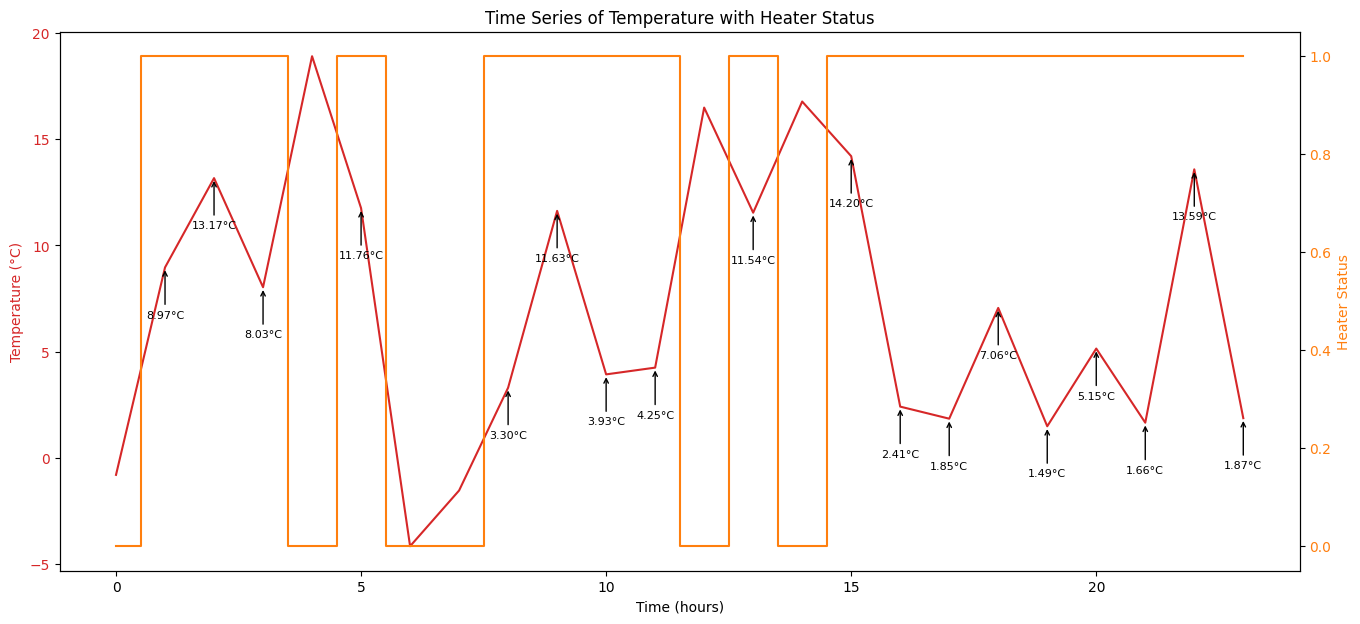

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
time_periods = np.arange(0, 24, 1)  # Assuming time periods in hours

# Generate random temperature values within heating thresholds
heating_min_threshold = 0
heating_max_threshold = 15
temperatures = np.random.uniform(heating_min_threshold - 5, heating_max_threshold + 5, size=len(time_periods))

# Determine when Heater is on based on strict temperature thresholds
heater_status = np.where((temperatures >= heating_min_threshold) & (temperatures <= heating_max_threshold), 1, 0)

# Plotting time series of temperature, Heater status, and AC status
fig, ax1 = plt.subplots(figsize=(16, 7))

color = 'tab:red'
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Temperature (°C)', color=color)
ax1.plot(time_periods, temperatures, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis to plot Heater status
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Heater Status', color=color)
ax2.step(time_periods, heater_status, where='mid', color=color, label='Heater ON')
ax2.tick_params(axis='y', labelcolor=color)

# Adding labels and title
plt.title('Time Series of Temperature with Heater Status')

# Annotating the plot with temperature values where Heater is ON
for i, status in enumerate(heater_status):
    if status == 1:
        ax1.annotate(f'{temperatures[i]:.2f}°C', xy=(time_periods[i], temperatures[i]),
                     xytext=(time_periods[i], temperatures[i] - 2),
                     arrowprops=dict(facecolor='black', arrowstyle='->'),
                     fontsize=8, ha='center', va='top')

plt.show()


Right axis shows Heater status either 1 or 0 discrete only. Left axis shows temperature values. ON X Axis, time in hours.  At 0-15, Heater status is 1 and beyond this range, Heater turns off according to our settings.




1.   cooling_min_threshold = 15 degree Celsius
2.   cooling_max_threshold = 25 degree Celsius
3.   heating_min_threshold = 0  degree Celsius
4.   heating_max_threshold = 15 degree Celsius


#Setting Up Gateway...
**Address: http://localhost:6000/data**

In [ ]:


# Flask server setup
from flask import Flask, request, jsonify
from threading import Thread

app = Flask(__name__)
device_data = {}
server_running = True  # Flag to track if the server is running

@app.route('/data', methods=['POST'])
def receive_data():
    data = request.get_json()
    device_id = data.get('device_id')
    if device_id:
        device_data[device_id] = data.get('data')
        data=temp=data.get('data')
        print(f"Received data from device {device_id}: {data}")
        return jsonify({"status": "success", "message": "Data received"})
    else:
        return jsonify({"status": "error", "message": "Invalid data"})

def run_flask_app():
    app.run(port=6000, use_reloader=False, threaded=True)

def stop_flask_server():
    global server_running
    server_running = False

#Devices sending data through gateway link: **http://localhost:6000/data**

In [ ]:
import requests
flask_thread = Thread(target=run_flask_app)
flask_thread.start()

# Send data for smart thermostats
data_payload_thermostats = {"device_id": "smart_thermostats", "data": {"temperature": 22.5}}
response_thermostats = requests.post("http://localhost:6000/data", json=data_payload_thermostats)
print(response_thermostats.json())

# Send data for motion sensors
data_payload_motion_sensors = {"device_id": "motion_sensors", "data": {"motion_detected": True}}
response_motion_sensors = requests.post("http://localhost:6000/data", json=data_payload_motion_sensors)
print(response_motion_sensors.json())

# Send data for humidity sensors
data_payload_humidity_sensors = {"device_id": "humidity_sensors", "data": {"humidity": 50}}
response_humidity_sensors = requests.post("http://localhost:6000/data", json=data_payload_humidity_sensors)
print(response_humidity_sensors.json())


# Send data for air quality monitors
data_payload_air_quality_monitors = {"device_id": "air_quality_monitors", "data": {"co2_level": 400}}
response_air_quality_monitors = requests.post("http://localhost:6000/data", json=data_payload_air_quality_monitors)
print(response_air_quality_monitors.json())

# Send data for smart appliances
data_payload_smart_appliances = {"device_id": "smart_appliances", "data": {"power_usage": 100}}
response_smart_appliances = requests.post("http://localhost:6000/data", json=data_payload_smart_appliances)
print(response_smart_appliances.json())


# Send data for smart_blinds sensors
data_payload_humidity_sensors = {"device_id": "smart_blinds", "data": {"humidity": 50}}
response_humidity_sensors = requests.post("http://localhost:6000/data", json=data_payload_humidity_sensors)
print(response_humidity_sensors.json())
# Add similar data for other devices


# Stop the Flask server after simulation
stop_flask_server()

# Wait for the Flask thread to finish
flask_thread.join()

INFO:werkzeug:127.0.0.1 - - [05/Dec/2023 16:08:20] "POST /data HTTP/1.1" 200 -


Received data from device smart_thermostats: {'temperature': 22.5}
{'message': 'Data received', 'status': 'success'}
 * Serving Flask app '__main__'
 * Debug mode: off


Address already in use
Port 6000 is in use by another program. Either identify and stop that program, or start the server with a different port.
INFO:werkzeug:127.0.0.1 - - [05/Dec/2023 16:08:20] "POST /data HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [05/Dec/2023 16:08:20] "POST /data HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [05/Dec/2023 16:08:20] "POST /data HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [05/Dec/2023 16:08:20] "POST /data HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [05/Dec/2023 16:08:20] "POST /data HTTP/1.1" 200 -


Received data from device motion_sensors: {'motion_detected': True}
{'message': 'Data received', 'status': 'success'}
Received data from device humidity_sensors: {'humidity': 50}
{'message': 'Data received', 'status': 'success'}
Received data from device air_quality_monitors: {'co2_level': 400}
{'message': 'Data received', 'status': 'success'}
Received data from device smart_appliances: {'power_usage': 100}
{'message': 'Data received', 'status': 'success'}
Received data from device smart_blinds: {'humidity': 50}
{'message': 'Data received', 'status': 'success'}


# **Checking Rush hours**

In [ ]:
cooling_min_threshold = 15
cooling_max_threshold = 25
heating_min_threshold = 0
heating_max_threshold = 15

import time
import random as rd
import requests
# Send data for smart thermostats
flask_thread = Thread(target=run_flask_app)
flask_thread.start()

data=[15,25,0]
i=0
while (i<len(data)):
  temp=data[i]
  data_payload_thermostats = {"device_id": "smart_thermostats", "data": {"temperature": temp}}
  response_thermostats = requests.post("http://localhost:6000/data", json=data_payload_thermostats)
  print(response_thermostats.json())
  if temp==cooling_min_threshold:
    print("message: Stop AC")
  if temp==cooling_max_threshold:
    print("message: Turn ON AC")
  if temp==heating_min_threshold:
    print("message: Turn ON Heater")
  if temp==heating_max_threshold:
    print("message: Stop Heater")
  print("----------------------\n")
  print("----------------------\n")
  print("----------------------\n")
  time.sleep(5)
  i+=1
stop_flask_server()

# Wait for the Flask thread to finish
flask_thread.join()

 * Serving Flask app '__main__'
Received data from device smart_thermostats: {'temperature': 15}
 * Debug mode: off


INFO:werkzeug:127.0.0.1 - - [05/Dec/2023 16:07:43] "POST /data HTTP/1.1" 200 -
Address already in use

{'message': 'Data received', 'status': 'success'}
message: Stop AC
message: Stop Heater
----------------------

----------------------

----------------------




Port 6000 is in use by another program. Either identify and stop that program, or start the server with a different port.
INFO:werkzeug:127.0.0.1 - - [05/Dec/2023 16:07:48] "POST /data HTTP/1.1" 200 -


Received data from device smart_thermostats: {'temperature': 25}
{'message': 'Data received', 'status': 'success'}
message: Turn ON AC
----------------------

----------------------

----------------------



INFO:werkzeug:127.0.0.1 - - [05/Dec/2023 16:07:53] "POST /data HTTP/1.1" 200 -


Received data from device smart_thermostats: {'temperature': 0}
{'message': 'Data received', 'status': 'success'}
message: Turn ON Heater
----------------------

----------------------

----------------------



In [ ]:
import pandas as pd

# Assuming you have a list to store received data
received_data = [
    {'data': {'temperature': 15}, 'message': 'Stop AC, Stop Heater'},
    {'data': {'temperature': 25}, 'message': 'Turn ON AC'},
    {'data': {'temperature': 0}, 'message': 'Turn ON Heater'},
    # Add more data entries as needed
]

# Create an empty DataFrame
df = pd.DataFrame(columns=['Temperature', 'Message'])

# Process each received data entry
for entry in received_data:
    temperature = entry['data'].get('temperature', None)
    message = entry.get('message', None)

    # Append data to the DataFrame
    df = df.append({'Temperature': temperature, 'Message': message}, ignore_index=True)

# Display the resulting DataFrame
df


<ipython-input-11-5c2af592708d>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Temperature': temperature, 'Message': message}, ignore_index=True)
<ipython-input-11-5c2af592708d>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Temperature': temperature, 'Message': message}, ignore_index=True)
<ipython-input-11-5c2af592708d>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Temperature': temperature, 'Message': message}, ignore_index=True)


,Temperature,Message
0,15,"Stop AC, Stop Heater"
1,25,Turn ON AC
2,0,Turn ON Heater
